In [1]:
# Imports
import os
import numpy as np
from pydub import AudioSegment
import librosa
import librosa.display
from matplotlib import pyplot as plt
%matplotlib inline 
import IPython.display as ipd
from IPython.display import Audio
import pandas as pd
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import sklearn
from sklearn.preprocessing import StandardScaler
import scipy.signal
import scipy.signal
import numpy
from numpy import asarray
import statistics
import audiolazy
import os
import seaborn as sn
import scipy.signal
import math
import matplotlib.pyplot as plt
import librosa
from shapely.geometry import  LineString
from shapely.geometry import MultiPoint
import glob

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba ve

In [2]:
# FILTERING
def filter(Path,file):
    file = Path+file
    y, sr = librosa.load(file)  
    samples, index = librosa.effects.trim(y,top_db = 15)
    time = librosa.get_duration(samples)
    print('Duration:',time)
    return samples,y
    

In [3]:
# Get features from Librosa
# hop length must be a multiple of 64
def getFeaturesfromLibrosa(samples):
    mfcc=librosa.feature.mfcc(samples, hop_length=128)
    poly_features=librosa.feature.poly_features(samples,hop_length=128)
    chroma_cens=librosa.feature.chroma_cens(samples, hop_length=128)
    chroma_cqt=librosa.feature.chroma_cqt(samples, hop_length=128)
    chroma_stft=librosa.feature.chroma_stft(samples, hop_length=128)
    tempogram=librosa.feature.tempogram(samples, hop_length=128)
    spectral_centroid=librosa.feature.spectral_centroid(samples, hop_length=128)[0]
    spectral_bandwidth=librosa.feature.spectral_bandwidth(samples, hop_length=128)[0]
    spectral_contrast=librosa.feature.spectral_contrast(samples, hop_length=128)[0]
    spectral_flatness=librosa.feature.spectral_flatness(samples, hop_length=128)[0]
    spectral_rolloff=librosa.feature.spectral_rolloff(samples, hop_length=128)[0]
    onset=librosa.onset.onset_detect(samples, hop_length=128)
    onset_strength=librosa.onset.onset_strength(samples, hop_length=128)
    zero_crossings=librosa.feature.zero_crossing_rate(samples, hop_length=128)[0]
    rms = librosa.feature.rms(samples, hop_length=128)[0]
    
    features_L = {'mfcc':mfcc[3],'poly_features':poly_features,'chroma_cens':chroma_cens,
                 'chroma_cqt':chroma_cqt,'tempogram':tempogram,'spectral_centroid':spectral_centroid,
                 'spectral_bandwidth':spectral_bandwidth,'spectral_contrast':spectral_contrast,
                  'spectral_flatness':spectral_flatness,'spectral_rolloff':spectral_rolloff,
                  'onset':onset,
                  'onset_strength':onset_strength,'zero_crossings':zero_crossings,'rms': rms}
   
    return features_L

In [4]:
# get features from Py Audio Analysis
def getFeaturesfromPyAudio(samples):
    sr = 22050
    F, f_names = ShortTermFeatures.feature_extraction(samples,sr, 0.050*sr, 0.00525*sr)
#                                                   (samples,sampling rate,frame rate,step size)
    Enthropy = F[1]
    features_P={'ZCR':F[1],'Energy':F[2],'Entropy of Energy':F[3],'Spectral Centroid':F[4],
                'Spectral Spread':F[5],'Spectral Entropy':F[6],'Spectral Flux':F[7],
                'Spectral Rolloff':F[8],'Chroma Deviation':F[34]
                }
    return features_P
    

In [5]:
# get Formants
def formantFrequency(audio, Fs):
        # Windowing the speech using Hamming Window
        audio1 = numpy.multiply(audio, numpy.hamming(len(audio))) 
        # applying pre-emphasis Filter
        pre_emp = [1., 0.63]
        audio1 = scipy.signal.lfilter([1], pre_emp, audio1)
        ncoef = 2 + Fs // 1000
        (A, z) = audiolazy.lazy_lpc.lpc(audio1, ncoef)
        # converting oredered pair to 1d array
        A1 = []
        for key, value in A.items():
            A1.append(value)
        roots = numpy.roots(A1)  # Finding Roots
        # finding roots in complex conjugate pair
        roots = [r for r in roots if numpy.imag(r) >= 0]
        # getting angles
        angles = numpy.arctan2(numpy.imag(roots), numpy.real(roots))
        # Getting frequencies
        (freq) = sorted(angles * (Fs / float(2 * math.pi)))
        indices = numpy.argsort(angles * (Fs / float(2 * math.pi)))
        roots_order = []
        i = 0
        while i < len(roots):
            roots_order.append(roots[indices[i]])
            i = i + 1
        bw = numpy.multiply(-1 / 2.0 * (Fs / float(2 * math.pi)), numpy.log(numpy.abs(roots_order)))
        nn = 1
        formants = []
        for kk in range(0, len(freq)):
            if freq[kk] > 0 and bw[kk] < 400:
                formants.append(freq[kk])
                nn += 1
        return formants
def formantContours(audio):
    Fs = 22050
    interval = 5.8
    # input audio file , Frame rate ,interval of time
    # output Formant Frequency graph wrt to time (msec)
    Frames_number = (Fs) * (interval / 1000.0)
    print('Frames_number formants',Frames_number)
    start = 0
    end = Frames_number - 1
    length = len(audio)
    frequency1 = []
    frequency2 = []
    frequency3 = []
    end_time = librosa.core.samples_to_time(len(audio), sr=22050)
    i = []
    t = 0

    while (end < length):

        signal = audio[int(start):int(end)]

        # Finding Formant frequency for giving interval
        freq = formantFrequency(signal, Fs)

        # Removing formant frequencies less than 200 Hz
        j = 0
        k = len(freq)
        while (k > 0):
            k = k - 1
            if (freq[j] < 200):
                del freq[j]

            if (freq[j] > 200):
                break

        # freq= [item for item in freq if item>200]
        if (len(freq) > 5):
            i.append(end / float(Fs))
            frequency1.append(freq[0])
            frequency2.append(freq[1])
            frequency3.append(freq[2])
        start = end + 1
        end = end + Frames_number

    signal = audio[int(start):length - 1]
    freq = formantFrequency(signal, Fs)
    for k in freq:
        if (k <= 200):
            freq.remove(k)
        if (k > 200):
            break

    if (len(freq) > 5):
        i.append(length - 1 / float(Fs))
        frequency1.append(freq[0])
        frequency2.append(freq[1])
        frequency3.append(freq[2])
        i.pop()
        i.insert(len(i),end_time)
    print('i',len(i))
    return frequency1, frequency2, frequency3,i
def normalize(samples, axis=0):
        return sklearn.preprocessing.minmax_scale(samples, axis=axis)
def getIntersection(l1,l2):
    points = list()
    intersection = [x for x in zip(l1,l2)]
    for x in intersection:
        if x[0]==x[1]:
            points.append(intersection.index(x))
    return points
def getFormantRatios(frequency1, frequency2, frequency3,time,samples):
    Ratio1 = [i / j for i, j in zip(frequency2, frequency1)]
    Ratio2 = [i / j for i, j in zip(frequency3, frequency2)]
    line_1 = asarray(LineString(np.column_stack((time, normalize(Ratio1)))))
    line_2 = asarray(LineString(np.column_stack((time, normalize(Ratio2)))))
#     print('Formants frames:',len(time))
#     formants_i = line_1.intersection(line_2)
    return Ratio1,Ratio2

In [6]:
def getList(LineString,List): 
    for i in LineString:
        i = i[1]
        List.append(i)
    return List
def getTime(LineString,List):
    for i in LineString:
        i = i[0]
        List.append(i)
    return List
def getSameLengths1(feature,Librosa):
    lib = len(Librosa)
    fea = len(feature)
    if(lib > fea):
        i = lib - fea
        feature += i * [0]

    if(lib < fea):
        i = fea - lib
        feature = feature[:lib]
    return feature

In [7]:
# DATASET
def createDataset(features_L,features_P,samples,Ratio1,Ratio2):
        frames = range(len(features_L['spectral_centroid']))
        t = librosa.frames_to_time(frames,hop_length=128)
#         print('Librosa frames:',len(t))
        frames1 = range(len(features_P['Entropy of Energy']))
        t1 = librosa.frames_to_time(frames1,hop_length=128)
#         print('PyAudio frames:',len(t1))
        
        mfcc = asarray(LineString(np.column_stack((t, normalize(features_L['mfcc'])))))
        spectral_centroid = asarray(LineString(np.column_stack((t, normalize(features_L['spectral_centroid'])))))
        spectral_bandwidth= asarray(LineString(np.column_stack((t, normalize(features_L['spectral_bandwidth'])))))
        spectral_contrast = asarray(LineString(np.column_stack((t, normalize(features_L['spectral_contrast'])))))
        spectral_flatness = asarray(LineString(np.column_stack((t, normalize(features_L['spectral_flatness'])))))
        spectral_rolloff = asarray(LineString(np.column_stack((t, normalize(features_L['spectral_rolloff'])))))
        onset_strength = asarray(LineString(np.column_stack((t, normalize(features_L['onset_strength'])))))
        zero_crossings = asarray(LineString(np.column_stack((t, normalize(features_L['zero_crossings'])))))
        rms = asarray(LineString(np.column_stack((t, normalize(features_L['rms'])))))
        zcr = asarray(LineString(np.column_stack((t1, normalize(features_P['ZCR'])))))
        energy = asarray(LineString(np.column_stack((t1, normalize(features_P['Energy'])))))
        entropy = asarray(LineString(np.column_stack((t1, normalize(features_P['Entropy of Energy'])))))
        centroid = asarray(LineString(np.column_stack((t1, normalize(features_P['Spectral Centroid'])))))
        spectral_spread = asarray(LineString(np.column_stack((t1, normalize(features_P['Spectral Spread'])))))
        spectral_entropy = asarray(LineString(np.column_stack((t1, normalize(features_P['Spectral Entropy'])))))
        spectral_flux = asarray(LineString(np.column_stack((t1, normalize(features_P['Spectral Flux'])))))
        spectral_rolloff = asarray(LineString(np.column_stack((t1, normalize(features_P['Spectral Rolloff'])))))
        chroma_deviation = asarray(LineString(np.column_stack((t1, normalize(features_P['Chroma Deviation'])))))
        
        Mfcc = list()
        Mfcc = getList(mfcc,Mfcc)
        
        Spectral_centroid = list()
        Spectral_centroid = getList(spectral_centroid,Spectral_centroid)
        
        Spectral_bandwidth = list()
        Spectral_bandwidth = getList(spectral_bandwidth,Spectral_bandwidth)
        
        
        Spectral_contrast = list()
        Spectral_contrast = getList(spectral_contrast,Spectral_contrast)
        
        Spectral_flatness = list()
        Spectral_flatness = getList(spectral_flatness,Spectral_flatness)
        
        Spectral_rolloff = list()
        Spectral_rolloff = getList(spectral_rolloff,Spectral_rolloff)
        Spectral_rolloff = getSameLengths1(Spectral_rolloff,Spectral_flatness)
        
        Onset_strength = list()
        Onset_strength = getList(onset_strength,Onset_strength)
        
        Zero_crossings = list()
        Zero_crossings = getList(zero_crossings,Zero_crossings)
        
        Rms = list()
        Rms = getList(rms,Rms)
        
        time = list()
        time = getTime(rms,time)
        
        Entropy = list()
        Entropy = getList(entropy,Entropy)
        Entropy = getSameLengths1(Entropy,Rms)
        
        Energy = list()
        Energy = getList(energy,Energy)
        Energy = getSameLengths1(Energy,Rms)
        
        Centroid = list()
        Centroid = getList(centroid,Centroid)
        Centroid = getSameLengths1(Centroid,Rms)
        
        ZCR = list()
        ZCR = getList(zcr,ZCR)
        ZCR = getSameLengths1(ZCR,Rms)
        
        Spectral_Spread = list()
        Spectral_Spread = getList(spectral_spread,Spectral_Spread)
        Spectral_Spread = getSameLengths1(Spectral_Spread,Rms)
        
        Spectral_Entropy = list()
        Spectral_Entropy = getList(spectral_entropy,Spectral_Entropy)
        Spectral_Entropy = getSameLengths1(Spectral_Entropy,Rms)
        
        Spectral_Flux = list()
        Spectral_Flux = getList(spectral_flux,Spectral_Flux)
        Spectral_Flux = getSameLengths1(Spectral_Flux,Rms)
        
        Spectral_Rolloff = list()
        Spectral_Rolloff = getList(spectral_rolloff,Spectral_Rolloff)
        Spectral_Rolloff = getSameLengths1(Spectral_Rolloff,Rms)
        
        Chroma_Deviation = list()
        Chroma_Deviation = getList(chroma_deviation,Chroma_Deviation)
        Chroma_Deviation = getSameLengths1(Chroma_Deviation,Rms)
        
        f2f1 = [x for x in Ratio1]
        f2f1 =getSameLengths1(f2f1,Rms)
               
        f3f2 = [x for x in Ratio2]
        f3f2 =getSameLengths1(f3f2,Rms)
       
#         print(len(Energy),len(Rms),len(f3f2))

        df = {'time':time,'Mfcc':Mfcc,'RMS': Rms,'Zero_crossings':Zero_crossings,
              'Spectral_centroid':Spectral_centroid,'Spectral_bandwidth':Spectral_bandwidth,
             'Spectral_contrast':Spectral_contrast,'Spectral_flatness':Spectral_flatness,
              'Spectral_rolloff':Spectral_rolloff,'Onset_strength':Onset_strength,'Entropy':Entropy,
              'Energy':Energy,'Centroid':Centroid,'ZCR':ZCR,'Spectral_Spread':Spectral_Spread,
              ' Spectral_Entropy': Spectral_Entropy,'Spectral_Flux':Spectral_Flux,
              'Spectral_Rolloff':Spectral_Rolloff,'Chroma_Deviation':Chroma_Deviation,
              'f2f1':f2f1,'f3f2':f3f2
             }    
               
        dataSet = pd.DataFrame(df)
        return dataSet

In [33]:
def selectFeatures(dataSet):
    corrMatrix = dataSet.corr()
#     plt.figure(figsize=(15,8))
#     sn.heatmap(corrMatrix, annot=True)
#     plt.show()
    columns = np.full((corrMatrix.shape[0],), True, dtype=bool)
    for i in range(corrMatrix.shape[0]):
        for j in range(i+1, corrMatrix.shape[0]):
            if corrMatrix.iloc[i,j] >= abs(0.8):
                if columns[j]:
                    columns[j] = False
    selected_columns = dataSet.columns[columns]
    print(selected_columns)
    dataSet = dataSet[selected_columns]
#     print(dataSet)
    return dataSet,selected_columns
    

In [34]:
def getPointOfIntersection(dataSet,selected_columns):
    Row_list =[] 
    stdDev = []
    intersections = []
    for i in range((dataSet.shape[0])): # Iterate over each row 
        Row_list.append(list(dataSet.iloc[i,:])) # Using iloc to access the values of  
                                            # the current row denoted by "i" 
    for j in Row_list:
        standardDeviation = statistics.pstdev(j) 
        stdDev.append(standardDeviation)
    possitions = [i for i,x in enumerate(stdDev) if x < 1.2]
    time = dataSet['time']
    time = [x for x in time]

    for n in possitions:
        i = time[n]
        intersections.append(i)
    return intersections
#     print(intersections)
    

In [35]:
def getAudio(samples,partitions):
    try:
        z1 = partitions[0]
        s1 = librosa.core.time_to_samples(z1, sr=22050)
        z2 = partitions[1]
        s2 = librosa.core.time_to_samples(z2, sr=22050)
        ipd.display(ipd.Audio(data=samples,rate=22050))
        alpha1 = samples[0:s1]
        ipd.display(ipd.Audio(data=alpha1,rate=22050))
        alpha2 = samples[s1:s2]
        ipd.display(ipd.Audio(data=alpha2,rate=22050))
        alpha3 = samples[s2:]
        ipd.display(ipd.Audio(data=alpha3,rate=22050))
    except Exception as E:
        print('Index Error')
    

In [36]:
def plotIntersections(samples,intersections):
    partitions = []
    intersections = [x for x in intersections if 0.1<x<0.4]
    l1 = [x for x in intersections if 0.1<x<0.2]
    l2 = [x for x in intersections if 0.2<x<0.3]
    l3 = [x for x in intersections if 0.3<x<0.4] 
    try:
            z1 = statistics.mean(l1)
            partitions.append(z1)
            z2 = statistics.mean(l2)
            partitions.append(z2)
    except Exception as E:
            pass
    plt.figure(figsize=(8,4))
    librosa.display.waveplot(samples, sr=22050, alpha=0.3)
    plt.vlines(partitions,-1,1,color='g')
#     plt.vlines(markers,-1,1,color='r')
    plt.grid()
#     plt.legend(['','calculated','Marked'], loc='upper left')
    plt.show()
    return partitions

H_chaman-1iN2M0sw68P8uLoqxu4SwOtaHOs1-1589857472925.wav
Duration: 0.5804988662131519
Frames_number formants 127.88999999999999
i 100
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_bandwidth',
       'Spectral_contrast', 'Onset_strength', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


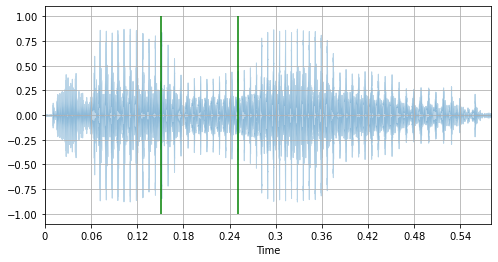

------------------------------------------------------------
H_chaman-cWT4AOhITUWOX6TRgsQbKAQNTTA3-1589392102435.wav
Duration: 1.18421768707483
Frames_number formants 127.88999999999999
i 205
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Spectral_rolloff', 'Onset_strength', 'Entropy', 'Energy', 'ZCR',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


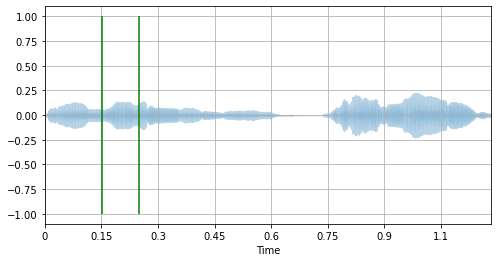

------------------------------------------------------------
H_chaman-cWT4AOhITUWOX6TRgsQbKAQNTTA3-1589801867129.wav
Duration: 0.5340589569160997
Frames_number formants 127.88999999999999
i 92
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       'Spectral_Spread', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


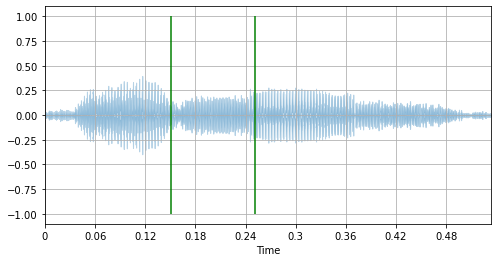

------------------------------------------------------------
H_chaman-CzLM923ClYV2pigdLbwsjFgLlus1-1590380508582.wav
Duration: 0.7720634920634921
Frames_number formants 127.88999999999999
i 133
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Spectral_rolloff', 'Onset_strength', 'Entropy', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


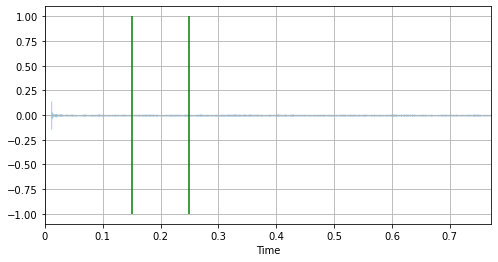

------------------------------------------------------------
H_chaman-CzLM923ClYV2pigdLbwsjFgLlus1-1590980037894.wav
Duration: 1.0216780045351475
Frames_number formants 127.88999999999999
i 176
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_bandwidth',
       'Spectral_contrast', 'Onset_strength', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


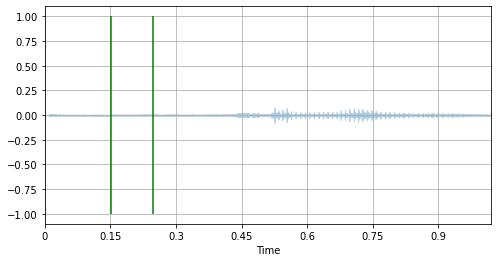

------------------------------------------------------------
H_chaman-CzLM923ClYV2pigdLbwsjFgLlus1-1591415486583.wav
Duration: 0.8359183673469388
Frames_number formants 127.88999999999999
i 144
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Onset_strength', 'Energy', ' Spectral_Entropy', 'Chroma_Deviation',
       'f2f1', 'f3f2'],
      dtype='object')


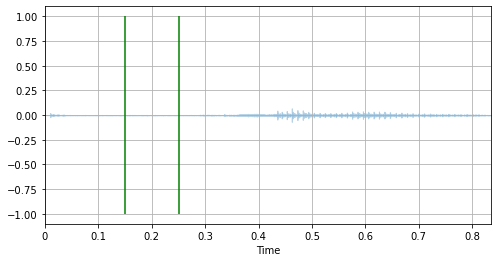

------------------------------------------------------------
H_chaman-gkJTULfq4BXF333QFN4eSBYqJGk1-1590636198499.wav
Duration: 0.5108390022675737
Frames_number formants 127.88999999999999
i 88
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy', 'Centroid',
       'Spectral_Spread', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


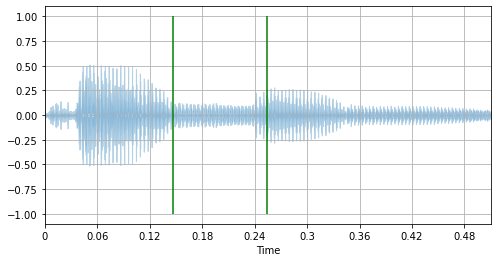

------------------------------------------------------------
H_chaman-gkJTULfq4BXF333QFN4eSBYqJGk1-1590726830275.wav
Duration: 1.0448979591836736
Frames_number formants 127.88999999999999
i 179
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Spectral_flatness', 'Spectral_rolloff', 'Onset_strength', 'Entropy',
       'Energy', 'Centroid', 'ZCR', ' Spectral_Entropy', 'Chroma_Deviation',
       'f2f1', 'f3f2'],
      dtype='object')


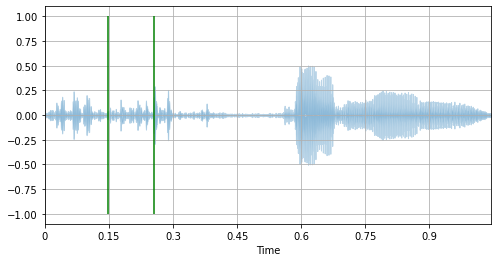

------------------------------------------------------------
H_chaman-gkJTULfq4BXF333QFN4eSBYqJGk1-1590856917616.wav
Duration: 1.2770975056689342
Frames_number formants 127.88999999999999
i 219
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Spectral_rolloff', 'Onset_strength', 'Entropy', 'Energy', 'Centroid',
       'ZCR', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


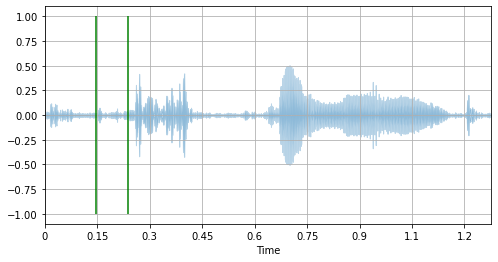

------------------------------------------------------------
H_chaman-jtqaeAx7GHYMKlmNO8VWPeIZF362-1589868351454.wav
Duration: 0.7430385487528345
Frames_number formants 127.88999999999999
i 129
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Spectral_rolloff', 'Onset_strength', 'Entropy',
       'Energy', 'Spectral_Spread', ' Spectral_Entropy', 'Spectral_Flux',
       'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


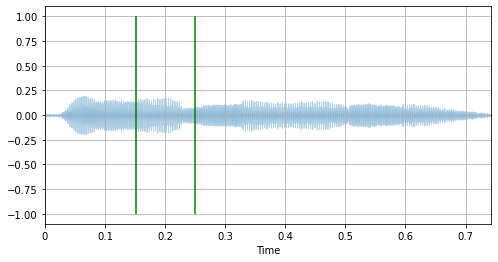

------------------------------------------------------------
H_chaman-lfkfWobmQufNuXs2L00rg8yRtFB2-1589683634471.wav
Duration: 0.34829931972789113
Frames_number formants 127.88999999999999
i 60
Index(['time', 'RMS', 'Spectral_centroid', 'Spectral_bandwidth',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Spectral_Flux', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


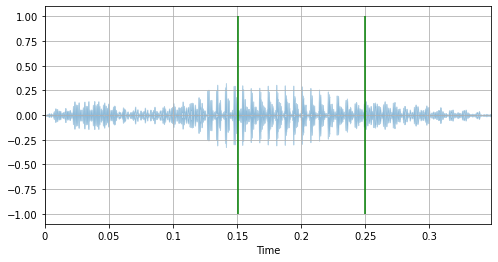

------------------------------------------------------------
H_chaman-Lv1f2t6NTrWQ5PdQGqRBQuJZoi72-1591130959020.wav
Duration: 0.44117913832199546
Frames_number formants 127.88999999999999
i 77
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Spectral_rolloff', 'Onset_strength', 'Entropy',
       'Energy', 'Spectral_Spread', ' Spectral_Entropy', 'Chroma_Deviation',
       'f2f1', 'f3f2'],
      dtype='object')


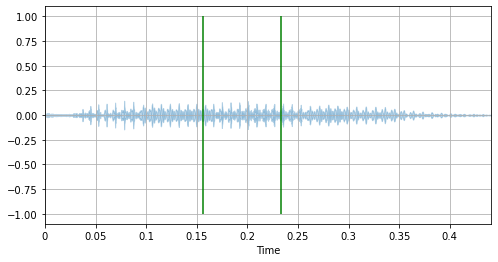

------------------------------------------------------------
H_chaman-m2My4jNa9Fct0zjEwbeDMAmo8ou1-1589205832511.wav
Duration: 0.9287981859410431
Frames_number formants 127.88999999999999
i 161
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Onset_strength', 'Energy', ' Spectral_Entropy', 'Chroma_Deviation',
       'f2f1', 'f3f2'],
      dtype='object')


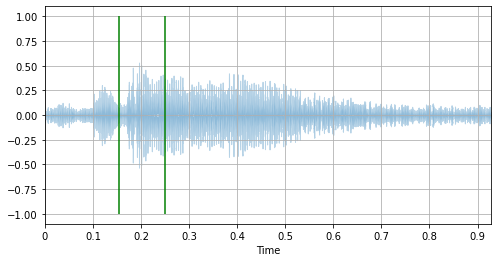

------------------------------------------------------------
H_chaman-muSrTPEv0VUGLiKwBB7nTZhF8Lq1-1589763103899.wav
Duration: 0.5108390022675737
Frames_number formants 127.88999999999999
i 89
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


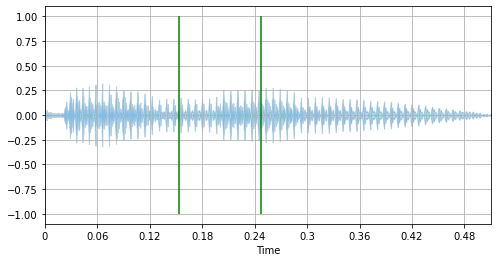

------------------------------------------------------------
H_chaman-muSrTPEv0VUGLiKwBB7nTZhF8Lq1-1589764184781.wav
Duration: 0.5108390022675737
Frames_number formants 127.88999999999999
i 89
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


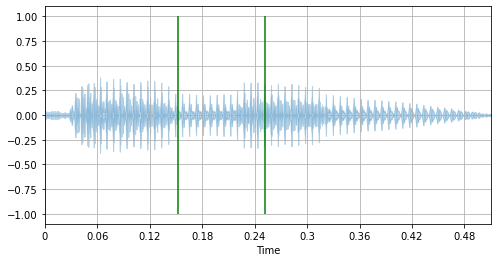

------------------------------------------------------------
H_chaman-muSrTPEv0VUGLiKwBB7nTZhF8Lq1-1590467087320.wav
Duration: 0.5804988662131519
Frames_number formants 127.88999999999999
i 101
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Spectral_rolloff', 'Onset_strength', 'Entropy',
       'Energy', 'Spectral_Spread', ' Spectral_Entropy', 'Spectral_Flux',
       'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


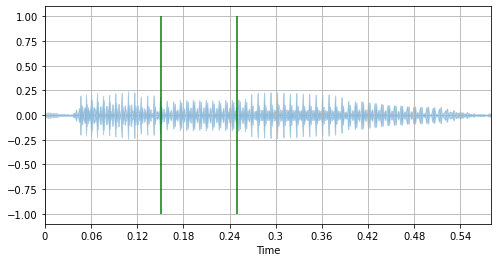

------------------------------------------------------------
H_chaman-muSrTPEv0VUGLiKwBB7nTZhF8Lq1-1590501226968.wav
Duration: 0.5804988662131519
Frames_number formants 127.88999999999999
i 101
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


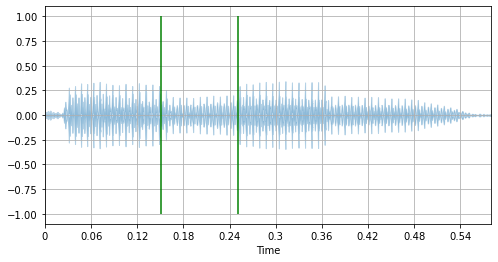

------------------------------------------------------------
H_chaman-muSrTPEv0VUGLiKwBB7nTZhF8Lq1-1590724597548.wav
Duration: 0.5340589569160997
Frames_number formants 127.88999999999999
i 93
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


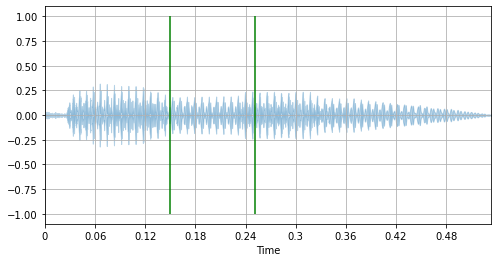

------------------------------------------------------------
H_chaman-N8gQNvlS3NMdrcQvggP0kttZabO2-1591503424562.wav
Duration: 0.4179591836734694
Frames_number formants 127.88999999999999
i 72
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_bandwidth', 'Spectral_contrast', 'Onset_strength', 'Energy',
       'Centroid', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


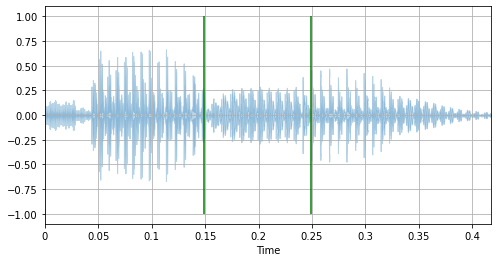

------------------------------------------------------------
H_chaman-oDlpDhdbjsQnRYiQx4PyONq2ISo1-1589202825530.wav
Duration: 0.3947392290249433
Frames_number formants 127.88999999999999
i 69
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_bandwidth',
       'Spectral_contrast', 'Onset_strength', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


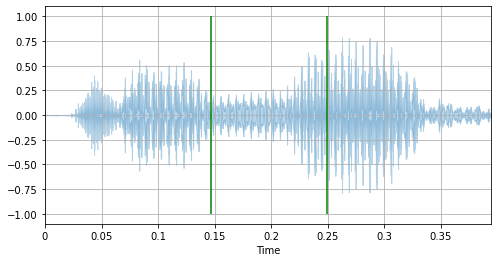

------------------------------------------------------------
H_chaman-r4UktPT17ggU7PwZbkCg8jB3odG3-1590574505299.wav
Duration: 0.5340589569160997
Frames_number formants 127.88999999999999
i 93
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Onset_strength', 'Energy', 'Centroid', ' Spectral_Entropy',
       'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


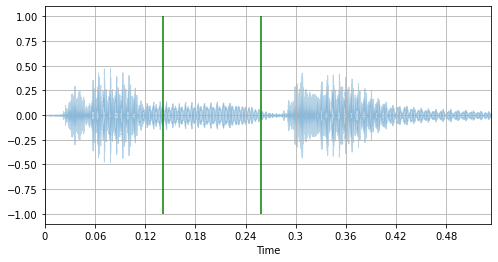

------------------------------------------------------------
H_chaman-UQMwfWXmgXXBi1bw3xVNx0qsncl2-1589380636874.wav
Duration: 0.3947392290249433
Frames_number formants 127.88999999999999
i 68
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


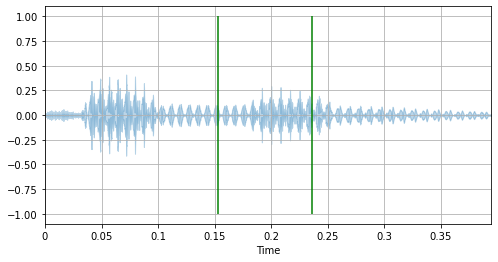

------------------------------------------------------------
H_chaman-UQMwfWXmgXXBi1bw3xVNx0qsncl2-1589443288548.wav
Duration: 0.3947392290249433
Frames_number formants 127.88999999999999
i 69
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_bandwidth', 'Spectral_contrast', 'Onset_strength', 'Entropy',
       'Energy', 'Centroid', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


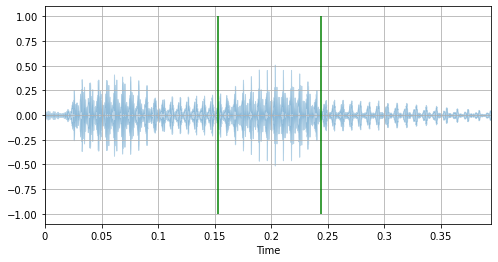

------------------------------------------------------------
H_chaman-Vazt8BHwcMZWuFDJFKjkoxzk6LG3-1589372527296.wav
Duration: 0.5572789115646258
Frames_number formants 127.88999999999999
i 97
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_bandwidth',
       'Spectral_contrast', 'Onset_strength', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


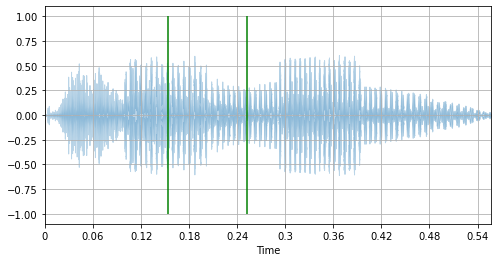

------------------------------------------------------------
H_chaman-Vazt8BHwcMZWuFDJFKjkoxzk6LG3-1589521488230.wav
Duration: 0.8359183673469388
Frames_number formants 127.88999999999999
i 145
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_bandwidth',
       'Spectral_contrast', 'Onset_strength', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


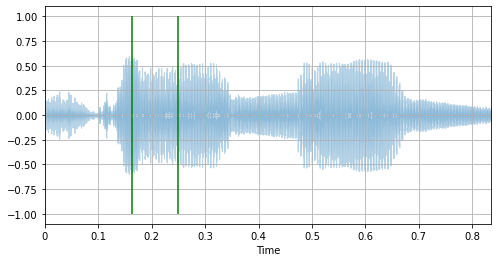

------------------------------------------------------------
H_chaman-w8Vum2f8zkQ4fciT6aGzxHowjW83-1589377342494.wav
Duration: 0.5108390022675737
Frames_number formants 127.88999999999999
i 89
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       'Spectral_Spread', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


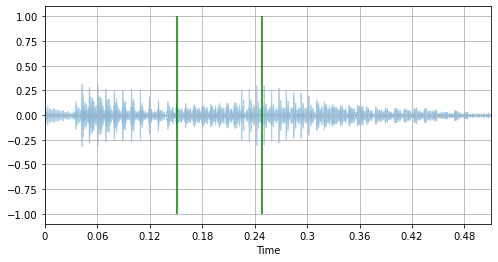

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1589338643045.wav
Duration: 0.5108390022675737
Frames_number formants 127.88999999999999
i 88
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Spectral_rolloff', 'Onset_strength', 'Entropy',
       'Energy', 'Spectral_Spread', ' Spectral_Entropy', 'Spectral_Flux',
       'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


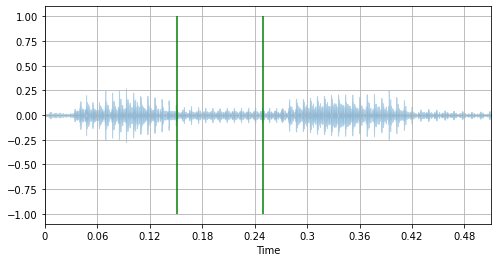

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1589431099835.wav
Duration: 0.5572789115646258
Frames_number formants 127.88999999999999
i 97
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Spectral_rolloff', 'Onset_strength', 'Entropy',
       'Energy', 'Spectral_Spread', ' Spectral_Entropy', 'Chroma_Deviation',
       'f2f1', 'f3f2'],
      dtype='object')


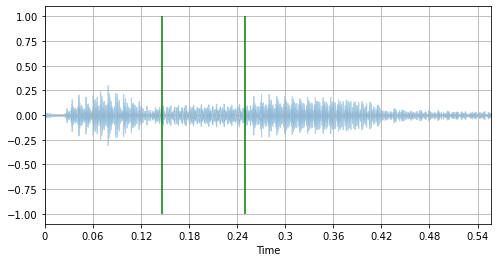

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1589559047339.wav
Duration: 0.5340589569160997
Frames_number formants 127.88999999999999
i 90
Index(['time', 'Mfcc', 'RMS', 'Spectral_centroid', 'Spectral_contrast',
       'Onset_strength', 'Entropy', 'Energy', ' Spectral_Entropy',
       'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


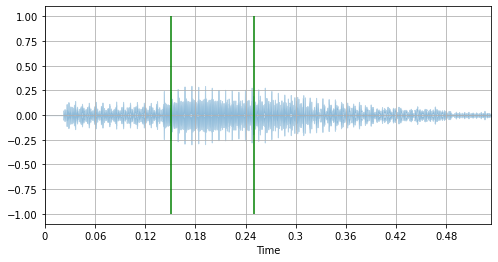

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1589598162144.wav
Duration: 0.5804988662131519
Frames_number formants 127.88999999999999
i 101
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


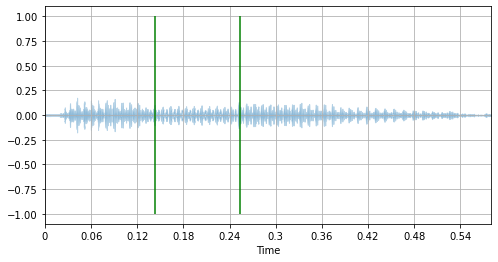

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1589861144552.wav
Duration: 0.4876190476190476
Frames_number formants 127.88999999999999
i 83
Index(['time', 'Mfcc', 'RMS', 'Spectral_centroid', 'Spectral_bandwidth',
       'Spectral_contrast', 'Spectral_flatness', 'Onset_strength', 'Entropy',
       'Energy', 'Centroid', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


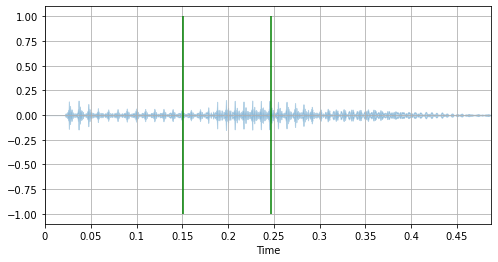

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1589985411605.wav
Duration: 0.6965986394557823
Frames_number formants 127.88999999999999
i 121
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Energy', 'Spectral_Spread',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


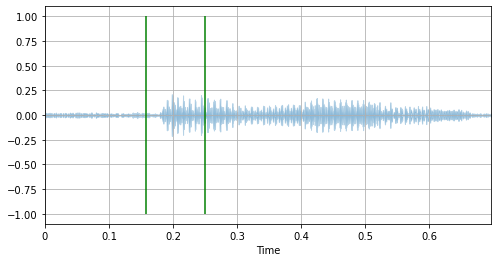

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1590029518774.wav
Duration: 0.905578231292517
Frames_number formants 127.88999999999999
i 157
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       'Spectral_Spread', ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


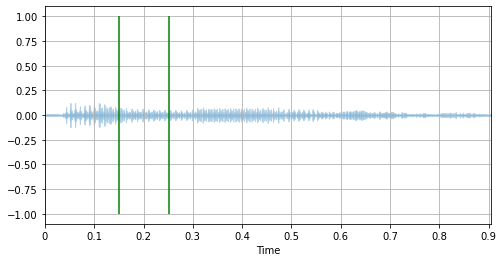

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1590117202925.wav
Duration: 0.603718820861678
Frames_number formants 127.88999999999999
i 103
Index(['time', 'Mfcc', 'RMS', 'Spectral_centroid', 'Spectral_bandwidth',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


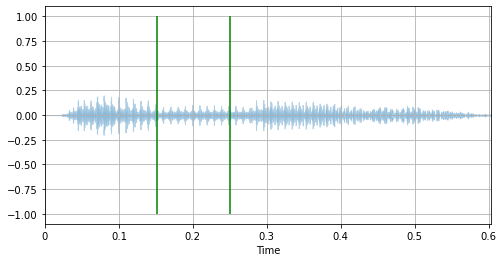

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1590202517698.wav
Duration: 0.46439909297052157
Frames_number formants 127.88999999999999
i 81
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_bandwidth', 'Spectral_contrast', 'Onset_strength', 'Entropy',
       'Energy', 'Centroid', 'Spectral_Spread', ' Spectral_Entropy',
       'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


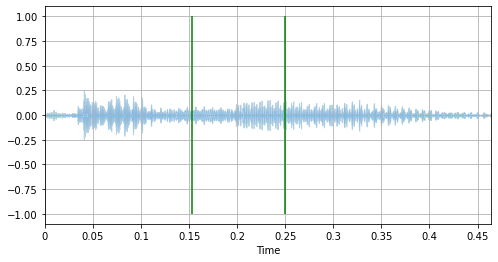

------------------------------------------------------------
H_chaman-wzzPQrlXnVPh70i90HbRK0vxn1C2-1590982353090.wav
Duration: 0.8823582766439909
Frames_number formants 127.88999999999999
i 153
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Spectral_Flux', 'Chroma_Deviation', 'f2f1',
       'f3f2'],
      dtype='object')


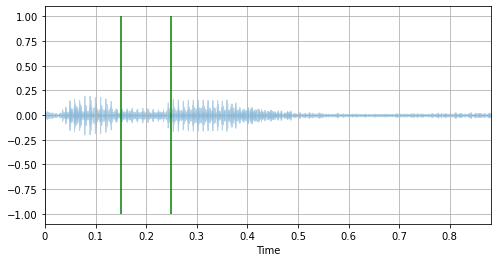

------------------------------------------------------------
H_chaman-xOvcmHuNwxfmEWL98X3ziLtl6tv2-1590592996161.wav
Duration: 1.0274829931972789
Frames_number formants 127.88999999999999
i 178
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_contrast',
       'Spectral_rolloff', 'Onset_strength', 'Energy', 'ZCR',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


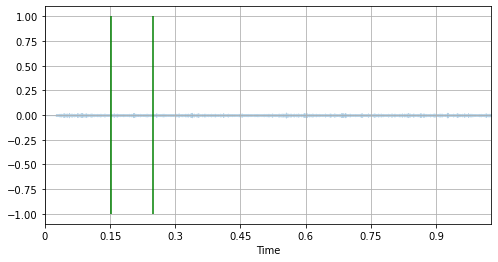

------------------------------------------------------------
H_chaman-z37K7Y5rHob1jQSWmY3j7rz4af72-1589646974811.wav
Duration: 0.4179591836734694
Frames_number formants 127.88999999999999
i 73
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy', 'Centroid',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


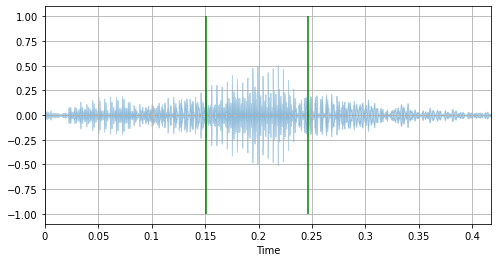

------------------------------------------------------------
H_chaman-z37K7Y5rHob1jQSWmY3j7rz4af72-1589683311726.wav
Duration: 0.301859410430839
Frames_number formants 127.88999999999999
i 53
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Spectral_rolloff', 'Onset_strength', 'Entropy',
       'Energy', 'ZCR', ' Spectral_Entropy', 'Spectral_Flux',
       'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


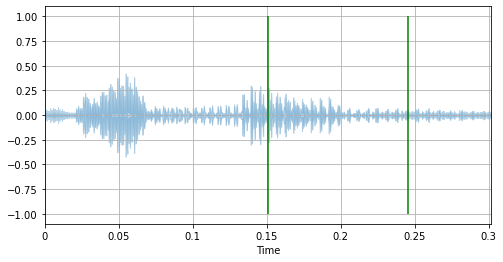

------------------------------------------------------------
H_chaman-z37K7Y5rHob1jQSWmY3j7rz4af72-1591194185497.wav
Duration: 0.44117913832199546
Frames_number formants 127.88999999999999
i 77
Index(['time', 'Mfcc', 'RMS', 'Zero_crossings', 'Spectral_centroid',
       'Spectral_contrast', 'Onset_strength', 'Entropy', 'Energy',
       ' Spectral_Entropy', 'Chroma_Deviation', 'f2f1', 'f3f2'],
      dtype='object')


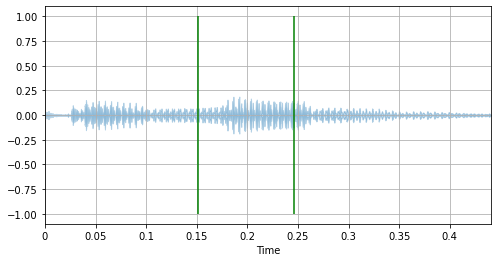

------------------------------------------------------------


In [37]:
Path = 'F:/DATA/Audiofiles/H_chaman/' #kamal
accuracy = {'1589392061463':(0.136, 0.2247),'1589868319276':(0.245, 0.377),
            '1589683609969':(0.0808, 0.1615),'1589763048866':(0.142, 0.228),
          '1589764145925':(0.143, 0.266),'1590467047977':(0.162,0.28),
            '1590501184893':(0.1481, 0.29),'1589202799855':(0.13, 0.2328),
            '1589380597101':(0.131, 0.230),'1589443257547':(0.1319, 0.235),
            '1589372495300':(0.138, 0.2403),'1589521464114':(0.1398, 0.2672),
            '1589377305166':(0.1453, 0.2556),'1589559013527':(0.1482,0.2544),
            '1589598131935':(0.1426,0.2620)    
         }
try:
    for root, directory, files in os.walk(Path):
        for file in files:
            print(file)
            samples,y = filter(Path,file)
            features_L = getFeaturesfromLibrosa(samples)
            features_P = getFeaturesfromPyAudio(samples)
            frequency1, frequency2, frequency3,time = formantContours(samples)
            Ratio1,Ratio2 = getFormantRatios(frequency1, frequency2, frequency3,time,samples)
            dataSet = createDataset(features_L,features_P,samples,Ratio1,Ratio2)
            dataSet,selected_columns = selectFeatures(dataSet)
            intersections = getPointOfIntersection(dataSet,selected_columns)
            partitions = plotIntersections(samples,intersections)
            getAudio(samples,partitions )  
           
            print('------------------------------------------------------------')
except FileNotFoundError as E :
       pass
